#Problem Defination and Data Gathering

The main objective of the JSS Problem is to find an optimal schedule that minimizes the makespan, the total time required to complete all jobs across all machines.

##Data Preparation

In [63]:
# Important Libraries
import pandas as pd
import numpy as np
import random
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Data Preparation
num_jobs = 4 #(J1 to J5)
num_tasks = 4 #(T1 to T5)
num_machines = 4 #(M1 to M5)
min_time = 1  # Minimum processing time
max_time = 100  # Maximum processing time

# Generate random data for the JSS problem
data = np.random.randint(min_time, max_time + 1, size=(num_jobs, num_tasks))
data_order = np.array([np.random.permutation(num_tasks) + 1 for _ in range(num_jobs)])
# Create job and operation labels
job_labels = [f'J{i+1}' for i in range(num_jobs)]
operation_labels = [f'T{i+1}' for i in range(num_tasks)]

#Creating dataframe for Operations Time
df = pd.DataFrame(data, columns=operation_labels, index=job_labels)
df.index.name = 'Time'
print(df)

#Creating dataframe for Operations Order
df_order = pd.DataFrame(data_order, columns=operation_labels, index=job_labels)
df_order.index.name = 'Order'
print(df_order)
# Saving as csv file
df.to_csv('JSP_dataset.csv')
df_order.to_csv('JSP_dataset_order.csv')


      T1  T2   T3  T4
Time                 
J1    30  80   63  33
J2    72  20   33  46
J3     5  26   21  18
J4    75  34  100  79
       T1  T2  T3  T4
Order                
J1      1   3   2   4
J2      2   1   3   4
J3      1   3   4   2
J4      1   4   3   2


##Solving The Job Shop Problem using Genetic Algorithms

###Chromosome Representation

In [65]:
# Flatten the operation order and add a machine assignment
chromosome = []
for job, tasks in df_order.iterrows():
    for task in tasks:
        chromosome.append(f'{job}{task}')
print("Example Chromosome:", chromosome)

Example Chromosome: ['J11', 'J13', 'J12', 'J14', 'J22', 'J21', 'J23', 'J24', 'J31', 'J33', 'J34', 'J32', 'J41', 'J44', 'J43', 'J42']


###Step1: Initialize Population

In [66]:
def generate_initial_population(population_size, num_jobs, num_tasks):
    population = []
    for _ in range(population_size):
        chromosome = []
        for job in range(1, num_jobs + 1):
            for task in range(1, num_tasks + 1):
                chromosome.append(f'J{job}T{task}')
        random.shuffle(chromosome)
        population.append(chromosome)
    return population

# Example usage:
population_size = 10  # Adjust based on problem complexity
population = generate_initial_population(population_size, num_jobs, num_tasks)
print("Initial Population:")
for i, individual in enumerate(population, 1):
    print(f"Chromosome {i}: {individual}")

Initial Population:
Chromosome 1: ['J4T3', 'J3T2', 'J1T1', 'J1T3', 'J4T4', 'J2T3', 'J2T4', 'J3T1', 'J4T2', 'J2T1', 'J3T4', 'J3T3', 'J1T2', 'J2T2', 'J1T4', 'J4T1']
Chromosome 2: ['J1T4', 'J4T2', 'J3T4', 'J1T1', 'J3T2', 'J2T1', 'J2T3', 'J3T1', 'J2T2', 'J1T3', 'J3T3', 'J2T4', 'J4T1', 'J4T3', 'J1T2', 'J4T4']
Chromosome 3: ['J1T3', 'J2T2', 'J4T4', 'J3T2', 'J2T4', 'J1T2', 'J1T4', 'J2T1', 'J3T1', 'J2T3', 'J3T3', 'J4T3', 'J4T2', 'J1T1', 'J3T4', 'J4T1']
Chromosome 4: ['J2T2', 'J1T3', 'J4T2', 'J1T4', 'J3T4', 'J3T1', 'J3T2', 'J4T3', 'J1T1', 'J4T4', 'J3T3', 'J2T4', 'J2T3', 'J2T1', 'J4T1', 'J1T2']
Chromosome 5: ['J2T4', 'J3T4', 'J3T2', 'J2T1', 'J1T4', 'J1T3', 'J4T1', 'J1T2', 'J3T1', 'J3T3', 'J4T3', 'J2T2', 'J1T1', 'J2T3', 'J4T2', 'J4T4']
Chromosome 6: ['J3T1', 'J1T2', 'J1T1', 'J1T4', 'J4T4', 'J4T1', 'J2T3', 'J2T4', 'J1T3', 'J2T2', 'J3T3', 'J4T3', 'J4T2', 'J3T2', 'J3T4', 'J2T1']
Chromosome 7: ['J4T3', 'J2T4', 'J1T3', 'J4T4', 'J3T2', 'J4T1', 'J3T3', 'J1T1', 'J2T2', 'J4T2', 'J1T4', 'J1T2', 'J3T1', 'J2

###Step 2: Fitness Function

In [67]:
def calculate_makespan(chromosome, df_times):
    num_machines = df_times.shape[1]
    machine_end_times = [0] * num_machines
    job_end_times = {job: 0 for job in df_times.index}

    for operation in chromosome:
        # Split job and task
        job, task = operation.split('T')  # e.g., "J1T6" -> "J1", "6"
        task = int(task) - 1  # Convert task to zero-based index

        # Assign machine (simple modulo-based assignment)
        machine = task % num_machines
        start_time = max(machine_end_times[machine], job_end_times[job])
        process_time = df_times.loc[job, f'T{task + 1}']
        finish_time = start_time + process_time

        # Update end times
        machine_end_times[machine] = finish_time
        job_end_times[job] = finish_time

    return max(machine_end_times)  # Return the makespan


###Step 3: Roulette Wheel Selection

In [68]:
def roulette_wheel_selection(population, fitness_values):
    total_fitness = sum(fitness_values)
    probabilities = [f / total_fitness for f in fitness_values]
    cumulative_prob = np.cumsum(probabilities)

    rand = random.random()
    for i, prob in enumerate(cumulative_prob):
        if rand <= prob:
            return population[i]


###Step 4: Crossover:




In [69]:
def one_point_crossover(parent1, parent2, crossover_rate):
  if random.random() < crossover_rate:
    point = random.randint(1, len(parent1) - 2)
    child1 = parent1[:point] + [gene for gene in parent2 if gene not in parent1[:point]]
    child2 = parent2[:point] + [gene for gene in parent1 if gene not in parent2[:point]]
  return child1, child2

###Step 5: Mutation

In [70]:
def mutation(chromosome, mutation_rate):
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(chromosome)), 2)
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

###Gantt Chart

In [77]:
def plot_gantt_chart(chromosome, df_times):
    num_machines = df_times.shape[1]
    machine_end_times = [0] * num_machines
    job_end_times = {job: 0 for job in df_times.index}
    gantt_data = []

    for operation in chromosome:
        # Extract job and task
        job = operation[:2]  # "J1" for example
        task = int(operation[3:]) - 1  # Extract task number (1-based indexing)

        # Assign machine (simple modulo-based assignment)
        machine = task % num_machines
        start_time = max(machine_end_times[machine], job_end_times[job])
        process_time = df_times.loc[job, f'T{task + 1}']
        finish_time = start_time + process_time

        gantt_data.append((machine, start_time, finish_time, job, f'T{task + 1}'))

        # Update end times
        machine_end_times[machine] = finish_time
        job_end_times[job] = finish_time

    # Plot Gantt Chart
    colors = sns.color_palette("hsv", len(gantt_data))
    plt.figure(figsize=(12, 6))
    for idx, (machine, start, finish, job, task) in enumerate(gantt_data):
        plt.barh(machine, finish - start, left=start, color=colors[idx], edgecolor='black', label=f'{job}-{task}')

    # Set y-axis labels to machine names
    machine_labels = [f"Machine {i+1}" for i in range(num_machines)]
    plt.yticks(range(num_machines), machine_labels)

    plt.xlabel("Time")
    plt.title("Gantt Chart")
    plt.legend(loc='upper right')
    plt.savefig('GanttChart.png')
    plt.show()


###Main Genetic Algorithm

Best Solution: ['J2T3', 'J1T3', 'J2T1', 'J3T3', 'J4T2', 'J4T4', 'J2T2', 'J1T2', 'J3T4', 'J3T2', 'J4T1', 'J1T1', 'J4T3', 'J2T4', 'J1T4', 'J3T1']
Best Makespan: 288


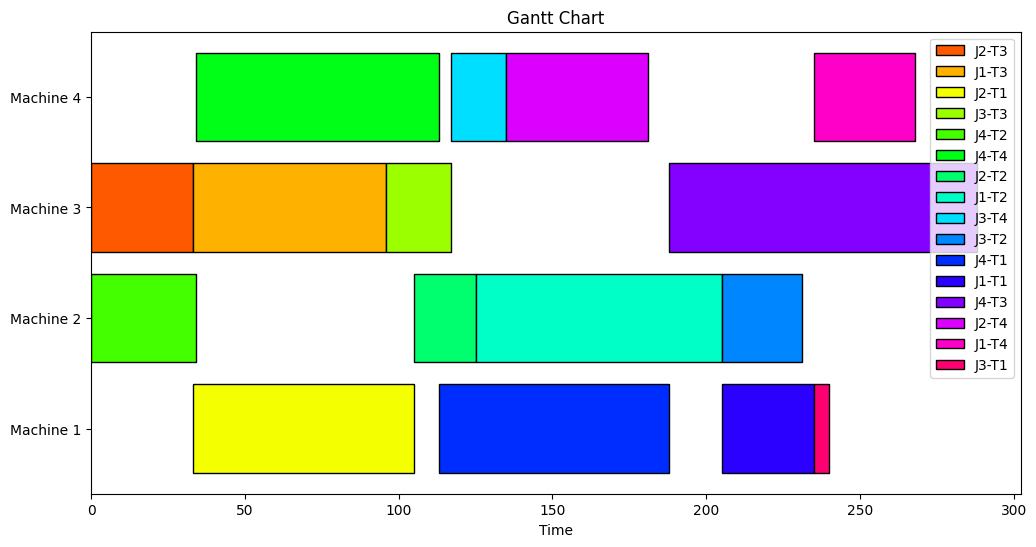

In [78]:
# Parameters
population_size = 10
num_generations = 500
mutation_rate = 0.6
crossover_rate = 0.6

# Generate Initial Population
population = generate_initial_population(population_size, num_jobs, num_tasks)

# Evaluate Fitness of Initial Population
def evaluate_population(population, df_times):
    fitness_values = [calculate_makespan(chromosome, df_times) for chromosome in population]
    return fitness_values

fitness_values = evaluate_population(population, df)

best_chromosome = None
best_fitness = float('inf')

for generation in range(num_generations):
    new_population = []
    fitness_values = evaluate_population(population, df)

    for _ in range(population_size // 2):  # Generate pairs
        # Selection
        parent1 = roulette_wheel_selection(population, fitness_values)
        parent2 = roulette_wheel_selection(population, fitness_values)

        # Crossover
        child1, child2 = one_point_crossover(parent1, parent2, crossover_rate)

        # Mutation
        child1 = mutation(child1, mutation_rate)
        child2 = mutation(child2, mutation_rate)

        new_population.extend([child1, child2])

    # Replace the old population
    population = new_population

    # Track the best solution
    fitness_values = evaluate_population(population, df)
    min_fitness = min(fitness_values)
    if min_fitness < best_fitness:
        best_fitness = min_fitness
        best_chromosome = population[fitness_values.index(min_fitness)]

    #print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

print("Best Solution:", best_chromosome)
print("Best Makespan:", best_fitness)

plot_gantt_chart(best_chromosome, df)


#Comparison with Baselines

##Heuristic - Shortest Processing Time

In [73]:
def shortest_processing_time(df_times):
    schedule = []
    machine_end_times = [0] * df_times.shape[1]
    job_end_times = {job: 0 for job in df_times.index}

    # Flatten job-task pairs and sort by processing time
    tasks = []
    for job in df_times.index:
        for task in df_times.columns:
            tasks.append((job, task, df_times.loc[job, task]))
    tasks.sort(key=lambda x: x[2])  # Sort by processing time

    for job, task, process_time in tasks:
        # Assign task to the first available machine
        machine = machine_end_times.index(min(machine_end_times))
        start_time = max(machine_end_times[machine], job_end_times[job])
        finish_time = start_time + process_time
        schedule.append((machine, start_time, finish_time, job, task))
        machine_end_times[machine] = finish_time
        job_end_times[job] = finish_time

    makespan = max(machine_end_times)
    return schedule, makespan

##Simulated Annealing




In [74]:
import math

def simulated_annealing(df_times, initial_solution, initial_temp=1000, cooling_rate=0.95, max_iterations=100):
    current_solution = initial_solution.copy()
    current_makespan = calculate_makespan(current_solution, df_times)
    best_solution = current_solution
    best_makespan = current_makespan
    temp = initial_temp

    for _ in range(max_iterations):
        # Generate a neighbor (swap two random tasks)
        neighbor = current_solution.copy()
        idx1, idx2 = random.sample(range(len(neighbor)), 2)
        neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]

        # Calculate neighbor's makespan
        neighbor_makespan = calculate_makespan(neighbor, df_times)

        # Accept neighbor with probability based on temperature
        if neighbor_makespan < current_makespan or math.exp((current_makespan - neighbor_makespan) / temp) > random.random():
            current_solution = neighbor
            current_makespan = neighbor_makespan

        # Update best solution
        if current_makespan < best_makespan:
            best_solution = current_solution
            best_makespan = current_makespan

        # Cool down
        temp *= cooling_rate

    return best_solution, best_makespan


##Visualization

In [79]:
import time

# Run GA
start_time = time.time()
ga_solution, ga_makespan = best_chromosome, best_fitness
ga_time = time.time() - start_time

# Run Heuristic
start_time = time.time()
heuristic_schedule, heuristic_makespan = shortest_processing_time(df)
heuristic_time = time.time() - start_time

# Run Simulated Annealing
start_time = time.time()
sa_solution, sa_makespan = simulated_annealing(df, best_chromosome)
sa_time = time.time() - start_time

# Print Comparison Results
print(f"Genetic Algorithm: Makespan = {ga_makespan}, Time = {ga_time:.2f}s")
print(f"Heuristic (SPT): Makespan = {heuristic_makespan}, Time = {heuristic_time:.2f}s")
print(f"Simulated Annealing: Makespan = {sa_makespan}, Time = {sa_time:.2f}s")


Genetic Algorithm: Makespan = 288, Time = 0.00s
Heuristic (SPT): Makespan = 338, Time = 0.00s
Simulated Annealing: Makespan = 288, Time = 0.02s


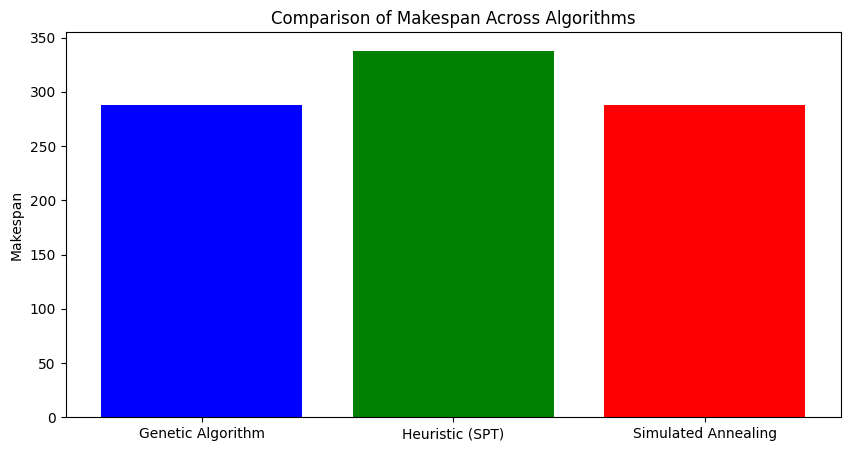

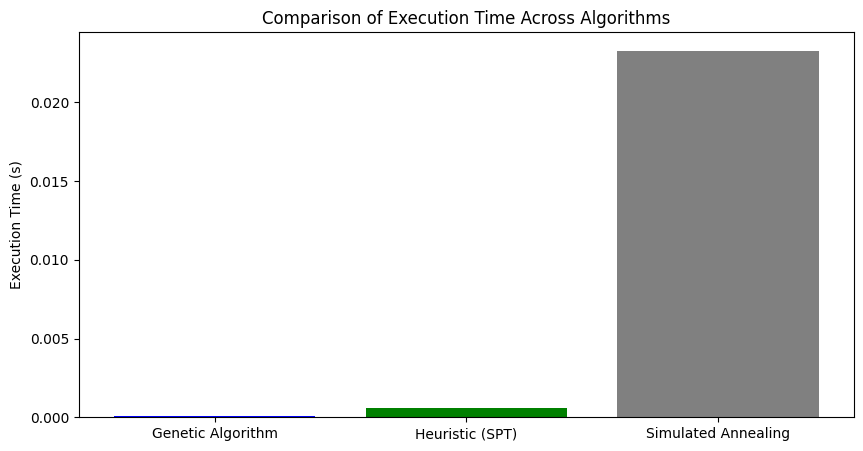

In [82]:
# Bar Chart Comparison
algorithms = ['Genetic Algorithm', 'Heuristic (SPT)', 'Simulated Annealing']
makespans = [ga_makespan, heuristic_makespan, sa_makespan]
times = [ga_time, heuristic_time, sa_time]

plt.figure(figsize=(10, 5))
plt.bar(algorithms, makespans, color=['blue', 'green', 'red'])
plt.ylabel('Makespan')
plt.title('Comparison of Makespan Across Algorithms')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(algorithms, times, color=['blue', 'green', 'gray'])
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Time Across Algorithms')
plt.savefig('TimeComparison.png')
plt.show()
